In [ ]:
! pip install kaggle

In [ ]:
from google.colab import files

# Kaggle API anahtarını yükleyin
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d ecoco2/household-appliances-power-consumption

 98% 245M/251M [00:02<00:00, 110MB/s] 
100% 251M/251M [00:02<00:00, 127MB/s]


In [ ]:
import zipfile
import os


zip_path = '/content/household-appliances-power-consumption.zip'

# Çıkartılacak dizini belirtin
extracted_folder_path = '/content/household-appliances-power-consumption'

# Zip dosyasını çıkart
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

# Çıkartılan dosyaları göster
os.listdir(extracted_folder_path)

['fridge_207.csv',
 'laptop_289.csv',
 'boiler_233.csv',
 'boiler_226.csv',
 'washing_machine_135.csv',
 'tv_290.csv',
 'phone_charger_282.csv',
 '0_smart_plugs_devices.csv',
 'coffee_97.csv',
 'coffee_54.csv',
 'solar_panel_325.csv',
 'radiator_309.csv',
 'dehumidifier_322.csv',
 'vacuum_254.csv',
 'dehumidifier_310.csv',
 'printer_286.csv',
 'washing_machine_218.csv',
 'fridge_317.csv',
 'washing_machine_52.csv',
 'internet_router_295.csv',
 'fridge_98.csv',
 'micro_wave_oven_147.csv',
 'micro_wave_oven_314.csv',
 'coffee_37.csv',
 'air_purifier_293.csv',
 'boiler_217.csv',
 'air_conditioner_222.csv',
 'washing_machine_157.csv',
 'washing_machine_343.csv',
 'screen_302.csv',
 'dryer_219.csv',
 'sound_system_252.csv',
 'freezer_249.csv',
 'fridge_284.csv',
 'internet_router_131.csv',
 'laptop_64.csv',
 'washing_machine_32.csv',
 'computer_44.csv',
 '3D_printer_29.csv',
 'vacuum_236.csv',
 'screen_146.csv',
 'fan_215.csv',
 'dishwasher_53.csv']

# I will use 2021-01... datasets, Screen dataset have few data, do not consider it.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.sequence import TimeseriesGenerator


color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [ ]:
"""gerekli_dosyalar = ["internet_router_295.csv", "vacuum_254.csv", "washing_machine_32.csv", "dishwasher_53.csv",
                       "air_purifier_293.csv", "fridge_317.csv", "laptop_289.csv"]

# başlangıç ve bitiş tarihlerini verme
 start_time = pd.to_datetime("2021-01-30 08:00:00").tz_localize('UTC')
 end_time = pd.to_datetime("2021-02-13 00:00:00").tz_localize('UTC')

# .csv dosyalarını sonradan birleştirmek için oluşturulan liste
csvlist = []
for each in gerekli_dosyalar:
  df = pd.read_csv(os.path.join(extracted_folder_path, each), parse_dates=['timestamp'])
  liste = df[(df['timestamp'] >= start_time) & (df['timestamp'] <= end_time)]
  csvlist.append(liste)"""

'gerekli_dosyalar = ["internet_router_295.csv", "vacuum_254.csv", "washing_machine_32.csv", "dishwasher_53.csv",\n                       "air_purifier_293.csv", "fridge_317.csv", "laptop_289.csv"]\n\n# başlangıç ve bitiş tarihlerini verme\n start_time = pd.to_datetime("2021-01-30 08:00:00").tz_localize(\'UTC\')\n end_time = pd.to_datetime("2021-02-13 00:00:00").tz_localize(\'UTC\')\n\n# .csv dosyalarını sonradan birleştirmek için oluşturulan liste\ncsvlist = []\nfor each in gerekli_dosyalar:\n  df = pd.read_csv(os.path.join(extracted_folder_path, each), parse_dates=[\'timestamp\'])\n  liste = df[(df[\'timestamp\'] >= start_time) & (df[\'timestamp\'] <= end_time)]\n  csvlist.append(liste)'

In [ ]:
gerekli_dosyalar = ["radiator_309.csv", "fridge_284.csv", "dehumidifier_310.csv", "computer_44.csv"]

# başlangıç ve bitiş tarihlerini verme
start_time = pd.to_datetime("2020-12-23 20:00:00+00:00")
end_time = pd.to_datetime("2020-12-30 23:50:00+00:00")

# .csv dosyalarını sonradan birleştirmek için oluşturulan liste
csvlist = []
for each in gerekli_dosyalar:
  df = pd.read_csv(os.path.join(extracted_folder_path, each), parse_dates=['timestamp'])
  liste = df[(df['timestamp'] >= start_time) & (df['timestamp'] <= end_time)]
  csvlist.append(liste)

In [ ]:
len(csvlist), csvlist[0], csvlist[3]

(4,
                        timestamp   power
 11875  2020-12-23 20:00:00+00:00  1190.0
 11876  2020-12-23 20:00:01+00:00  1190.0
 11877  2020-12-23 20:00:02+00:00  1190.0
 11878  2020-12-23 20:00:03+00:00  1190.0
 11879  2020-12-23 20:00:04+00:00  1190.0
 ...                          ...     ...
 630471 2020-12-30 23:49:56+00:00  1235.0
 630472 2020-12-30 23:49:57+00:00  1235.0
 630473 2020-12-30 23:49:58+00:00  1235.0
 630474 2020-12-30 23:49:59+00:00  1235.0
 630475 2020-12-30 23:50:00+00:00  1235.0
 
 [618601 rows x 2 columns],
                         timestamp  power
 1947916 2020-12-23 20:00:00+00:00  108.0
 1947917 2020-12-23 20:00:01+00:00  109.0
 1947918 2020-12-23 20:00:02+00:00  104.0
 1947919 2020-12-23 20:00:03+00:00  113.0
 1947920 2020-12-23 20:00:04+00:00  119.0
 ...                           ...    ...
 2566512 2020-12-30 23:49:56+00:00   93.0
 2566513 2020-12-30 23:49:57+00:00   92.0
 2566514 2020-12-30 23:49:58+00:00   92.0
 2566515 2020-12-30 23:49:59+00:00   93.0


In [ ]:
# bu kod index'leri sıfırlamak için çünkü index değerleri farklı olunca hep NaT değerler görünüyor düzenleme için sadece
for i in range(len(csvlist)):
  csvlist[i] = csvlist[i].reset_index(drop=True)
csvlist[0]

,timestamp,radiator_309.csv
0,2020-12-23 20:00:00+00:00,1190.0
1,2020-12-23 20:00:01+00:00,1190.0
2,2020-12-23 20:00:02+00:00,1190.0
3,2020-12-23 20:00:03+00:00,1190.0
4,2020-12-23 20:00:04+00:00,1190.0
...,...,...
618596,2020-12-30 23:49:56+00:00,1235.0
618597,2020-12-30 23:49:57+00:00,1235.0
618598,2020-12-30 23:49:58+00:00,1235.0
618599,2020-12-30 23:49:59+00:00,1235.0


In [ ]:
# daha önce listeye aldığımız tüm csv dosyalarını burada birleştiriyoruz ve hem indexler hem değerler düzgün görünüyor
df = pd.concat(csvlist, axis=1)
df

,timestamp,radiator_309.csv,timestamp,fridge_284.csv,timestamp,dehumidifier_310.csv,timestamp,computer_44.csv
0,2020-12-23 20:00:00+00:00,1190.0,2020-12-23 20:00:00+00:00,2.0,2020-12-23 20:00:00+00:00,3.0,2020-12-23 20:00:00+00:00,108.0
1,2020-12-23 20:00:01+00:00,1190.0,2020-12-23 20:00:01+00:00,2.0,2020-12-23 20:00:01+00:00,3.0,2020-12-23 20:00:01+00:00,109.0
2,2020-12-23 20:00:02+00:00,1190.0,2020-12-23 20:00:02+00:00,2.0,2020-12-23 20:00:02+00:00,3.0,2020-12-23 20:00:02+00:00,104.0
3,2020-12-23 20:00:03+00:00,1190.0,2020-12-23 20:00:03+00:00,2.0,2020-12-23 20:00:03+00:00,3.0,2020-12-23 20:00:03+00:00,113.0
4,2020-12-23 20:00:04+00:00,1190.0,2020-12-23 20:00:04+00:00,2.0,2020-12-23 20:00:04+00:00,3.0,2020-12-23 20:00:04+00:00,119.0
...,...,...,...,...,...,...,...,...
618596,2020-12-30 23:49:56+00:00,1235.0,2020-12-30 23:49:56+00:00,44.0,2020-12-30 23:49:56+00:00,324.0,2020-12-30 23:49:56+00:00,93.0
618597,2020-12-30 23:49:57+00:00,1235.0,2020-12-30 23:49:57+00:00,44.0,2020-12-30 23:49:57+00:00,324.0,2020-12-30 23:49:57+00:00,92.0
618598,2020-12-30 23:49:58+00:00,1235.0,2020-12-30 23:49:58+00:00,44.0,2020-12-30 23:49:58+00:00,324.0,2020-12-30 23:49:58+00:00,92.0
618599,2020-12-30 23:49:59+00:00,1235.0,2020-12-30 23:49:59+00:00,44.0,2020-12-30 23:49:59+00:00,324.0,2020-12-30 23:49:59+00:00,93.0


In [ ]:
df.iloc[:,1]

0         1190.0
1         1190.0
2         1190.0
3         1190.0
4         1190.0
           ...  
618596    1235.0
618597    1235.0
618598    1235.0
618599    1235.0
618600    1235.0
Name: radiator_309.csv, Length: 618601, dtype: float64

In [ ]:
# tüm enerjiyi hesaplamak için power değerlerini row'a göre topluyorum
df['total_power'] = df.iloc[:, 1::2].sum(axis=1)
df

,timestamp,radiator_309.csv,timestamp,fridge_284.csv,timestamp,dehumidifier_310.csv,timestamp,computer_44.csv,total_power
0,2020-12-23 20:00:00+00:00,1190.0,2020-12-23 20:00:00+00:00,2.0,2020-12-23 20:00:00+00:00,3.0,2020-12-23 20:00:00+00:00,108.0,1303.0
1,2020-12-23 20:00:01+00:00,1190.0,2020-12-23 20:00:01+00:00,2.0,2020-12-23 20:00:01+00:00,3.0,2020-12-23 20:00:01+00:00,109.0,1304.0
2,2020-12-23 20:00:02+00:00,1190.0,2020-12-23 20:00:02+00:00,2.0,2020-12-23 20:00:02+00:00,3.0,2020-12-23 20:00:02+00:00,104.0,1299.0
3,2020-12-23 20:00:03+00:00,1190.0,2020-12-23 20:00:03+00:00,2.0,2020-12-23 20:00:03+00:00,3.0,2020-12-23 20:00:03+00:00,113.0,1308.0
4,2020-12-23 20:00:04+00:00,1190.0,2020-12-23 20:00:04+00:00,2.0,2020-12-23 20:00:04+00:00,3.0,2020-12-23 20:00:04+00:00,119.0,1314.0
...,...,...,...,...,...,...,...,...,...
618596,2020-12-30 23:49:56+00:00,1235.0,2020-12-30 23:49:56+00:00,44.0,2020-12-30 23:49:56+00:00,324.0,2020-12-30 23:49:56+00:00,93.0,1696.0
618597,2020-12-30 23:49:57+00:00,1235.0,2020-12-30 23:49:57+00:00,44.0,2020-12-30 23:49:57+00:00,324.0,2020-12-30 23:49:57+00:00,92.0,1695.0
618598,2020-12-30 23:49:58+00:00,1235.0,2020-12-30 23:49:58+00:00,44.0,2020-12-30 23:49:58+00:00,324.0,2020-12-30 23:49:58+00:00,92.0,1695.0
618599,2020-12-30 23:49:59+00:00,1235.0,2020-12-30 23:49:59+00:00,44.0,2020-12-30 23:49:59+00:00,324.0,2020-12-30 23:49:59+00:00,93.0,1696.0


In [ ]:
# gereksiz timestamp ve power sütunlarından kurtulma kısmı
df = pd.DataFrame({'timestamp': df.iloc[:,0], 'power': df.iloc[:,-1]})
df

,timestamp,power
0,2020-12-23 20:00:00+00:00,1303.0
1,2020-12-23 20:00:01+00:00,1304.0
2,2020-12-23 20:00:02+00:00,1299.0
3,2020-12-23 20:00:03+00:00,1308.0
4,2020-12-23 20:00:04+00:00,1314.0
...,...,...
618596,2020-12-30 23:49:56+00:00,1696.0
618597,2020-12-30 23:49:57+00:00,1695.0
618598,2020-12-30 23:49:58+00:00,1695.0
618599,2020-12-30 23:49:59+00:00,1696.0


In [ ]:
# verideki en büyük ve en küçük power değerini bulur
highest_power = df['power'].max()
lowest_power = df['power'].min()
highest_power, lowest_power

(2622.0, 6.0)

In [ ]:
# verisetimizin totalde kapladı ortak gün sayısını verir
startTimestamp = df['timestamp'].iloc[0]
endTimestamp = df['timestamp'].iloc[-1]
print(endTimestamp - startTimestamp)

7 days 03:50:00


In [ ]:
# 10 dakikalık aralıklara bölerek toplam
df = df.resample('10Min', on='timestamp').power.sum().to_frame(name = 'power')
df.reset_index(inplace=True)
df

,timestamp,power
0,2020-12-23 20:00:00+00:00,435689.50
1,2020-12-23 20:10:00+00:00,438699.50
2,2020-12-23 20:20:00+00:00,383458.00
3,2020-12-23 20:30:00+00:00,426324.25
4,2020-12-23 20:40:00+00:00,441552.50
...,...,...
1027,2020-12-30 23:10:00+00:00,795831.00
1028,2020-12-30 23:20:00+00:00,780747.00
1029,2020-12-30 23:30:00+00:00,795840.75
1030,2020-12-30 23:40:00+00:00,799401.25


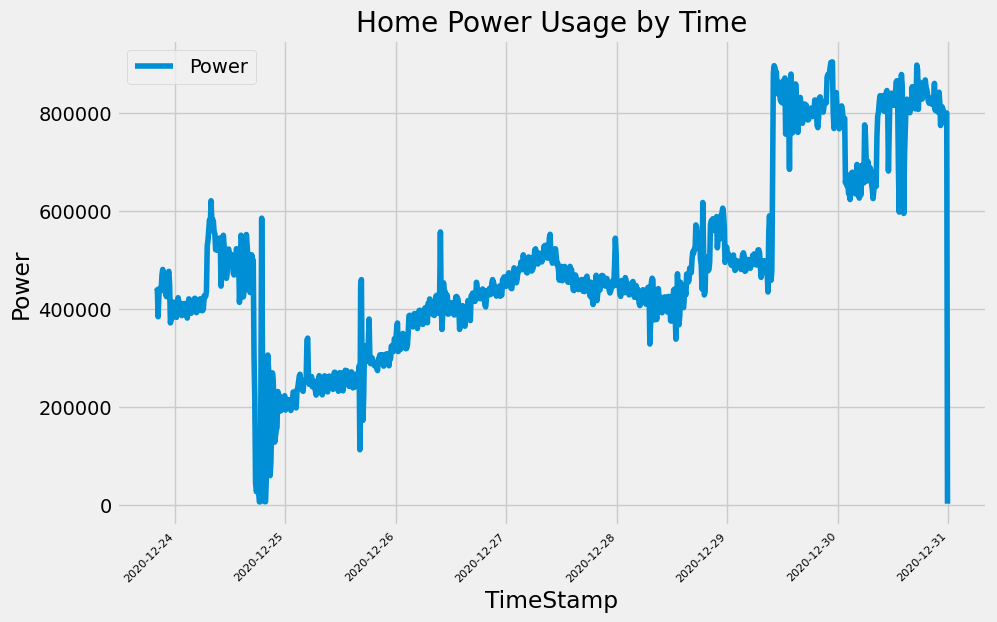

In [ ]:
# elde ettiğimiz verileri bir görselleştirelim
plt.figure(figsize=(10, 6))
plt.plot(df['timestamp'], df['power'], label='Power')
plt.title('Home Power Usage by Time')
plt.xlabel('TimeStamp')
plt.ylabel('Power')
plt.legend()
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.show()

In [ ]:
one_day_df = df.loc[(df['timestamp'] < '2020-12-25') & (df['timestamp'] >= '2020-12-24')]
one_day_df

,timestamp,power
24,2020-12-24 00:00:00+00:00,392435.75
25,2020-12-24 00:10:00+00:00,383519.75
26,2020-12-24 00:20:00+00:00,382152.75
27,2020-12-24 00:30:00+00:00,392990.00
28,2020-12-24 00:40:00+00:00,422369.50
...,...,...
163,2020-12-24 23:10:00+00:00,204799.75
164,2020-12-24 23:20:00+00:00,204284.75
165,2020-12-24 23:30:00+00:00,213893.50
166,2020-12-24 23:40:00+00:00,215044.25


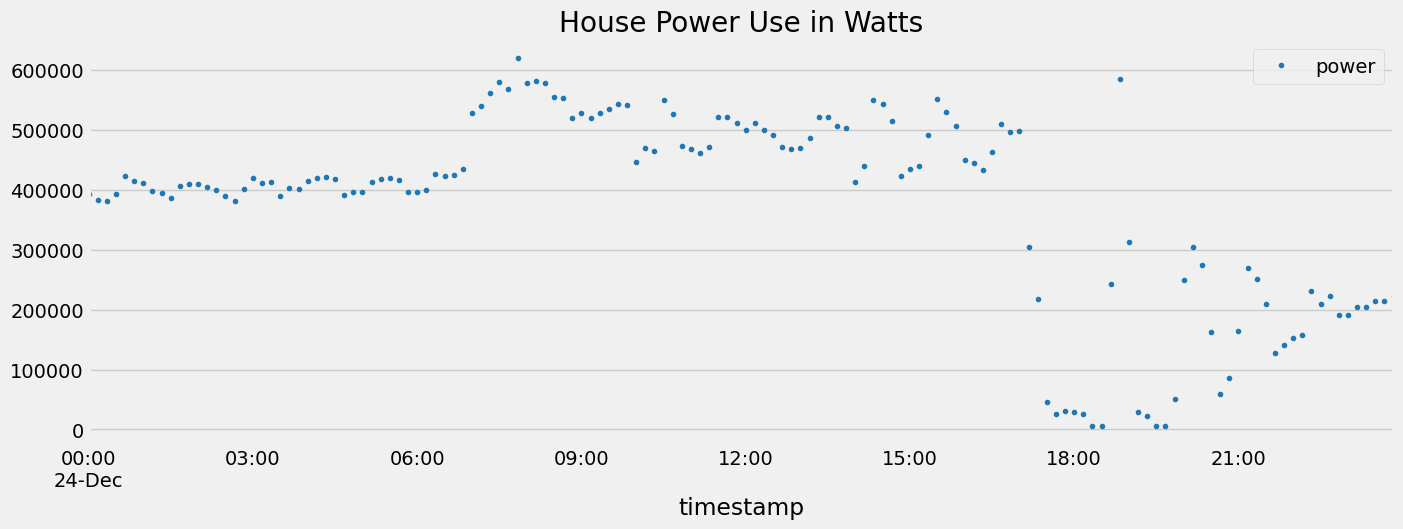

In [ ]:
one_day_df.plot(x='timestamp',
                y='power', style='.',
                figsize=(15, 5),
                color=color_pal,
                title='House Power Use in Watts')
plt.show()

## Train and Test Set

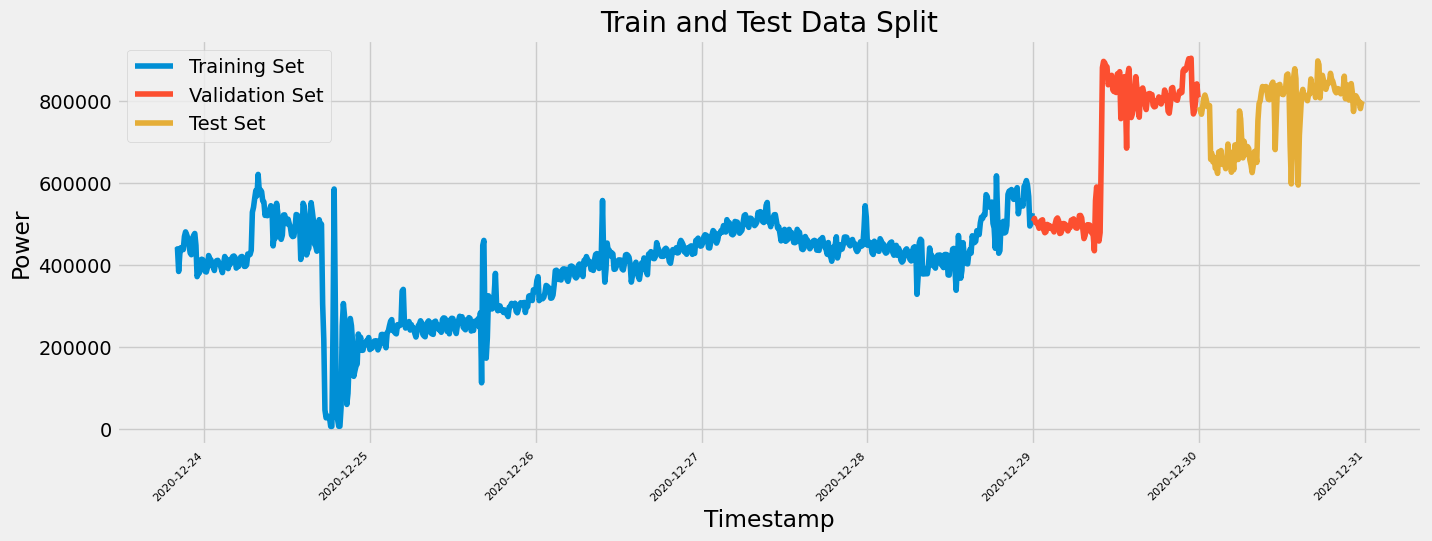

In [ ]:
train = df.loc[df['timestamp'] < '2020-12-29', ['timestamp', 'power']]
validation = df.loc[(df['timestamp'] >= '2020-12-29') & (df['timestamp'] < '2020-12-30'), ['timestamp', 'power']]
test = df.loc[(df['timestamp'] >= '2020-12-30') & (df['timestamp'] < '2020-12-30 23:50:00+00:00'), ['timestamp', 'power']]

fig, ax =  plt.subplots(figsize=(15, 5))
# train ve test plot kullanmak istiyorsak index'leri timestamp'e göre ayarlamamız gerekiyor o yüzden ax.plot kullandım
"""train.plot(x=df.loc[df['timestamp'] < '2020-12-30']['timestamp'], y='power', ax=ax, label='Training Set')
test.plot(x=df.loc[df['timestamp'] >= '2020-12-30']['timestamp'], y='power', ax=ax, label='Test Set')"""
ax.set_title("Train and Test Data Split")
ax.plot(train['timestamp'], train['power'], label='Training Set')
ax.plot(validation['timestamp'], validation['power'], label='Validation Set')
ax.plot(test['timestamp'], test['power'], label='Test Set')
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.xlabel('Timestamp')
plt.ylabel('Power')
plt.legend()
plt.show()

### Min Max Scaler

In [ ]:
"""
scaler = MinMaxScaler()
train['power'] = scaler.fit_transform(train['power'].values.reshape(-1, 1))
test['power'] = scaler.fit_transform(test['power'].values.reshape(-1, 1))
train, test"""

"\nscaler = MinMaxScaler()\ntrain['power'] = scaler.fit_transform(train['power'].values.reshape(-1, 1))\ntest['power'] = scaler.fit_transform(test['power'].values.reshape(-1, 1))\ntrain, test"

In [ ]:
def create_features(df):
  """Time Series Features"""
  df = df.copy()
  if 'timestamp' in df.columns:
      df['hour'] = df['timestamp'].dt.hour
      df['hourly_mean'] = df.groupby('hour')['power'].transform('mean')
      df['hourly_min'] = df.groupby('hour')['power'].transform('min')
      df['hourly_max'] = df.groupby('hour')['power'].transform('max')
      df['dayofweek'] = df['timestamp'].dt.dayofweek
      df['weekday'] = (df['dayofweek'] < 5).astype(int)

      # Lag özellikleri
      df['lag_1'] = df['power'].shift(1)

      # Diff özellikleri
      df['diff_1'] = df['power'].diff(1)
      df['diff_2'] = df['power'].diff(2)
  return df

## Create Model (XGBoost)

In [ ]:
train = create_features(train)
validation = create_features(validation)
test = create_features(test)

In [ ]:
train.columns, train, test

(Index(['timestamp', 'power', 'hour', 'hourly_mean', 'hourly_min', 'hourly_max',
        'dayofweek', 'weekday', 'lag_1', 'diff_1', 'diff_2'],
       dtype='object'),
                     timestamp      power  hour    hourly_mean  hourly_min  \
 0   2020-12-23 20:00:00+00:00  435689.50    20  391398.555556     59073.5   
 1   2020-12-23 20:10:00+00:00  438699.50    20  391398.555556     59073.5   
 2   2020-12-23 20:20:00+00:00  383458.00    20  391398.555556     59073.5   
 3   2020-12-23 20:30:00+00:00  426324.25    20  391398.555556     59073.5   
 4   2020-12-23 20:40:00+00:00  441552.50    20  391398.555556     59073.5   
 ..                        ...        ...   ...            ...         ...   
 739 2020-12-28 23:10:00+00:00  593615.00    23  401751.979167    191415.0   
 740 2020-12-28 23:20:00+00:00  566162.00    23  401751.979167    191415.0   
 741 2020-12-28 23:30:00+00:00  494344.00    23  401751.979167    191415.0   
 742 2020-12-28 23:40:00+00:00  500302.00    23  4017

In [ ]:
FEATURES = ['dayofweek', 'lag_1', 'diff_1', 'diff_2', 'hourly_min', 'hourly_max']
#  'hourly_min', 'hourly_max', 'hourly_mean', 'weekday', 'dayofweek', 'hour', 'weekday',
TARGET = 'power'

In [ ]:
X_train = train[FEATURES]
y_train = train[[TARGET]] # burada dataframe olarak tutmak için 2 tane [[]] kullanıyorum

X_val = validation[FEATURES]
y_val = validation[[TARGET]]

X_test = test[FEATURES]
y_test = test[[TARGET]]

In [ ]:
scaler = MinMaxScaler()
X_train.loc[:, FEATURES] = scaler.fit_transform(X_train.loc[:, FEATURES])
X_val.loc[:, FEATURES] = scaler.fit_transform(X_val.loc[:, FEATURES])
X_test.loc[:, FEATURES] = scaler.fit_transform(X_test.loc[:, FEATURES])

y_train[TARGET] = scaler.fit_transform(y_train[TARGET].values.reshape(-1, 1))
y_val[TARGET] = scaler.fit_transform(y_val[TARGET].values.reshape(-1, 1))
y_test[TARGET] = scaler.fit_transform(y_test[TARGET].values.reshape(-1, 1))

<ipython-input-73-4418dde19689>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.loc[:, FEATURES] = scaler.fit_transform(X_train.loc[:, FEATURES])
<ipython-input-73-4418dde19689>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val.loc[:, FEATURES] = scaler.fit_transform(X_val.loc[:, FEATURES])
<ipython-input-73-4418dde19689>:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior

In [ ]:
# Parametre aralıkları
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.1, 0.5, 1]
}

reg = xgb.XGBRegressor(n_estimators=500, early_stopping_rounds=50, learning_rate=0.001, random_state=42, reg_alpha=0.1)
# , early_stopping_rounds=30

# RandomizedSearchCV uygulama kısmı
random_search = RandomizedSearchCV(reg, param_distributions=param_dist, n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)

random_search.fit(X_train, y_train,
                  eval_set = [(X_train, y_train), (X_val, y_val)],
                  verbose=False)

# En iyi parametreleri ve sonucu görüntüleme kısmı
best_params = random_search.best_params_
print("En iyi parametreler:", random_search.best_params_)
print("En iyi skor:", np.sqrt(-random_search.best_score_))

En iyi parametreler: {'reg_alpha': 1, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.1}
En iyi skor: 0.07093402753481452


[0]	validation_0-rmse:0.16388	validation_1-rmse:0.27148
[50]	validation_0-rmse:0.03220	validation_1-rmse:0.34232
[100]	validation_0-rmse:0.02692	validation_1-rmse:0.34911
[150]	validation_0-rmse:0.02576	validation_1-rmse:0.35083
[200]	validation_0-rmse:0.02538	validation_1-rmse:0.35139
[250]	validation_0-rmse:0.02535	validation_1-rmse:0.35147
[299]	validation_0-rmse:0.02535	validation_1-rmse:0.35147


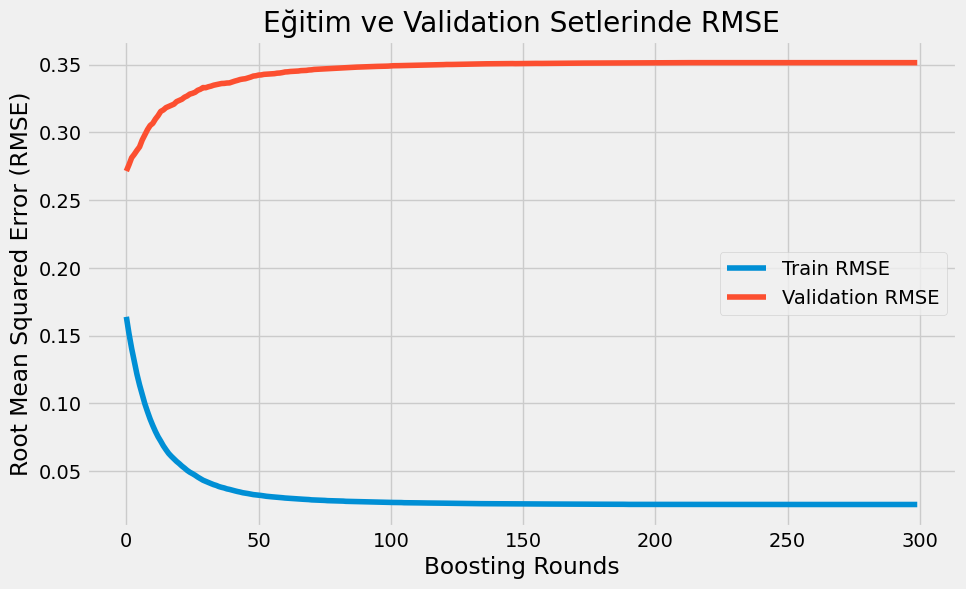

Train MAE: 0.015364281968497215
Train MSE: 0.0006426310748994886
Validation MAE: 0.09641725555562852
Validation MSE: 0.014021525771947615
Validation RMSE: 0.35147038999355285


In [ ]:
# XGBoost modelini en iyi parametrelerle tekrar eğitin
reg = xgb.XGBRegressor(**best_params)
evals_result = {}
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=50)

# Eğitim setindeki hataları alın
train_rmse = reg.evals_result()['validation_0']['rmse']
train_mae = mean_absolute_error(y_train, reg.predict(X_train))
train_mse = mean_squared_error(y_train, reg.predict(X_train))

# Validation setindeki hataları alın
val_rmse = reg.evals_result()['validation_1']['rmse']
val_mae = mean_absolute_error(y_val, reg.predict(X_val))
val_mse = mean_squared_error(y_val, reg.predict(X_val))

# Hataları görselleştirme
plt.figure(figsize=(10, 6))
plt.plot(train_rmse, label='Train RMSE')
plt.plot(val_rmse, label='Validation RMSE')
plt.xlabel('Boosting Rounds')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('Eğitim ve Validation Setlerinde RMSE')
plt.legend()
plt.show()

# Hataları görüntüleme
print(f'Train MAE: {train_mae}')
print(f'Train MSE: {train_mse}')
print(f'Validation MAE: {val_mae}')
print(f'Validation MSE: {val_mse}')

### Feature Importance

            importance
hourly_min    0.007218
hourly_max    0.015396
dayofweek     0.019303
diff_2        0.052791
diff_1        0.056094
lag_1         0.849198


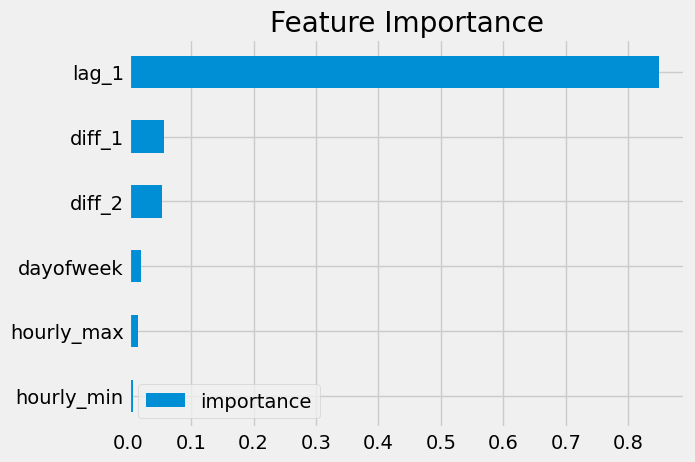

In [ ]:
importancedf = pd.DataFrame(data=reg.feature_importances_,
                            index=reg.feature_names_in_,
                            columns=['importance'])
importancedf = importancedf.sort_values('importance', ascending=True)
print(importancedf)
importancedf.plot(kind='barh', title='Feature Importance')
plt.show()

### Prediction on Test Data

In [ ]:
predict = reg.predict(X_test)
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
test, df

(                     timestamp      power  hour    hourly_mean  hourly_min  \
 888  2020-12-30 00:00:00+00:00  784619.50     0  788984.833333    767016.5   
 889  2020-12-30 00:10:00+00:00  777903.75     0  788984.833333    767016.5   
 890  2020-12-30 00:20:00+00:00  767016.50     0  788984.833333    767016.5   
 891  2020-12-30 00:30:00+00:00  784651.00     0  788984.833333    767016.5   
 892  2020-12-30 00:40:00+00:00  805852.75     0  788984.833333    767016.5   
 ...                        ...        ...   ...            ...         ...   
 1026 2020-12-30 23:00:00+00:00  800784.50    23  794520.900000    780747.0   
 1027 2020-12-30 23:10:00+00:00  795831.00    23  794520.900000    780747.0   
 1028 2020-12-30 23:20:00+00:00  780747.00    23  794520.900000    780747.0   
 1029 2020-12-30 23:30:00+00:00  795840.75    23  794520.900000    780747.0   
 1030 2020-12-30 23:40:00+00:00  799401.25    23  794520.900000    780747.0   
 
       hourly_max  dayofweek  weekday      lag_1  

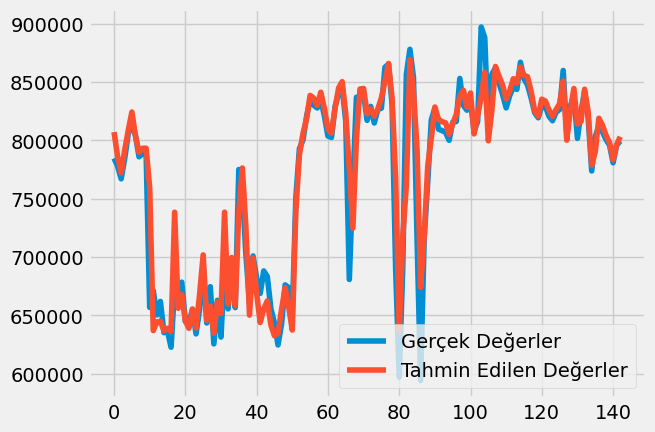

In [ ]:
# Min-max scaler kullanıldıysa, tahminleri tersine çevir
tahmin_edilen_degerler = scaler.inverse_transform(predict.reshape(-1, 1))
gercek_degerler = scaler.inverse_transform(y_test[TARGET].values.reshape(-1, 1))

# Gerçek ve tahmin edilen değerleri çiz
plt.plot(gercek_degerler, label='Gerçek Değerler')
plt.plot(tahmin_edilen_degerler, label='Tahmin Edilen Değerler')
plt.legend()
plt.show()

In [ ]:
# min-max scaler uygulamazsak
"""ax = df[['power']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend()
ax.set_title('Raw Data and Prediction')
plt.show()"""

"ax = df[['power']].plot(figsize=(15, 5))\ndf['prediction'].plot(ax=ax, style='.')\nplt.legend()\nax.set_title('Raw Data and Prediction')\nplt.show()"

In [ ]:
# RMSE değerini bulma
print(np.sqrt(mean_squared_error(y_test[TARGET], predict)))
print(mean_squared_error(y_test[TARGET], predict))
print(mean_absolute_error(y_test[TARGET], predict))

0.07619295504053455
0.00580536639780892
0.04293205798424545


## LSTM

In [ ]:
# bu kod index'leri sıfırlamak için çünkü index değerleri farklı olunca hep NaT değerler görünüyor düzenleme için sadece
gerekli_dosyalar = ["radiator_309.csv", "fridge_284.csv", "dehumidifier_310.csv", "computer_44.csv"]
for i in range(len(csvlist)):
  csvlist[i] = csvlist[i].reset_index(drop=True)
  csvlist[i] = csvlist[i].rename(columns={'power': gerekli_dosyalar[i]})
csvlist[0]

,timestamp,radiator_309.csv
0,2020-12-23 20:00:00+00:00,1190.0
1,2020-12-23 20:00:01+00:00,1190.0
2,2020-12-23 20:00:02+00:00,1190.0
3,2020-12-23 20:00:03+00:00,1190.0
4,2020-12-23 20:00:04+00:00,1190.0
...,...,...
618596,2020-12-30 23:49:56+00:00,1235.0
618597,2020-12-30 23:49:57+00:00,1235.0
618598,2020-12-30 23:49:58+00:00,1235.0
618599,2020-12-30 23:49:59+00:00,1235.0


In [ ]:
# daha önce listeye aldığımız tüm csv dosyalarını burada birleştiriyoruz ve hem indexler hem değerler düzgün görünüyor
df = pd.concat(csvlist, axis=1)

# tüm enerjiyi hesaplamak için power değerlerini row'a göre topluyorum
df['total_power'] = df.iloc[:, 1::2].sum(axis=1)

# gereksiz timestamp ve power sütunlarından kurtulma kısmı
timestampcol = df['timestamp'].iloc[:, 0]
df = df.loc[:, ['timestamp', 'radiator_309.csv', 'fridge_284.csv', 'dehumidifier_310.csv', 'computer_44.csv', 'total_power']]
df = df.drop(columns=['timestamp'])
df.insert(0, 'timestamp', timestampcol)
df

,timestamp,radiator_309.csv,fridge_284.csv,dehumidifier_310.csv,computer_44.csv,total_power
0,2020-12-23 20:00:00+00:00,1190.0,2.0,3.0,108.0,1303.0
1,2020-12-23 20:00:01+00:00,1190.0,2.0,3.0,109.0,1304.0
2,2020-12-23 20:00:02+00:00,1190.0,2.0,3.0,104.0,1299.0
3,2020-12-23 20:00:03+00:00,1190.0,2.0,3.0,113.0,1308.0
4,2020-12-23 20:00:04+00:00,1190.0,2.0,3.0,119.0,1314.0
...,...,...,...,...,...,...
618596,2020-12-30 23:49:56+00:00,1235.0,44.0,324.0,93.0,1696.0
618597,2020-12-30 23:49:57+00:00,1235.0,44.0,324.0,92.0,1695.0
618598,2020-12-30 23:49:58+00:00,1235.0,44.0,324.0,92.0,1695.0
618599,2020-12-30 23:49:59+00:00,1235.0,44.0,324.0,93.0,1696.0


In [ ]:
# verideki en büyük ve en küçük power değerini bulur
highest_power = df['total_power'].max()
lowest_power = df['total_power'].min()
highest_power, lowest_power

(2622.0, 6.0)

In [ ]:
# verisetimizin totalde kapladığı ortak gün sayısını verir
startTimestamp = df['timestamp'].iloc[0]
endTimestamp = df['timestamp'].iloc[-1]
print(endTimestamp - startTimestamp)

7 days 03:50:00


In [ ]:
# 10 dakikalık aralıklara bölerek toplam
columns_to_resample = ['radiator_309.csv', 'fridge_284.csv', 'dehumidifier_310.csv', 'computer_44.csv']

df_total_power = df.resample('10Min', on='timestamp')['total_power'].sum().to_frame(name='total_power')
df_total_power.reset_index(inplace=True)

df_radiator_309csv = df.resample('10Min', on='timestamp')['radiator_309.csv'].sum().to_frame(name='radiator_309.csv')
df_radiator_309csv.reset_index(inplace=True)

df_fridge_284csv = df.resample('10Min', on='timestamp')['fridge_284.csv'].sum().to_frame(name='fridge_284.csv')
df_fridge_284csv.reset_index(inplace=True)

df_dehumidifier_310csv = df.resample('10Min', on='timestamp')['dehumidifier_310.csv'].sum().to_frame(name='dehumidifier_310.csv')
df_dehumidifier_310csv.reset_index(inplace=True)

df_computer_44csv = df.resample('10Min', on='timestamp')['computer_44.csv'].sum().to_frame(name='computer_44.csv')
df_computer_44csv.reset_index(inplace=True)

# df_total_power, df_radiator_309csv, df_fridge_284csv, df_dehumidifier_310csv, df_computer_44csv are the resampled DataFrames

In [ ]:
# Merge the resampled DataFrames on the 'timestamp' column
result_df = df_total_power
result_df = pd.merge(result_df, df_radiator_309csv, on='timestamp', how='outer')
result_df = pd.merge(result_df, df_fridge_284csv, on='timestamp', how='outer')
result_df = pd.merge(result_df, df_dehumidifier_310csv, on='timestamp', how='outer')
result_df = pd.merge(result_df, df_computer_44csv, on='timestamp', how='outer')

# Now 'result_df' contains the merged DataFrames with a single 'timestamp' column
df = result_df
df

,timestamp,total_power,radiator_309.csv,fridge_284.csv,dehumidifier_310.csv,computer_44.csv
0,2020-12-23 20:00:00+00:00,435689.50,357759.00,13832.00,1800.0,62298.50
1,2020-12-23 20:10:00+00:00,438699.50,351203.25,26654.75,1800.0,59041.50
2,2020-12-23 20:20:00+00:00,383458.00,297021.50,25119.00,1786.5,59531.00
3,2020-12-23 20:30:00+00:00,426324.25,291477.50,24439.75,1800.0,108607.00
4,2020-12-23 20:40:00+00:00,441552.50,298882.00,4791.00,1800.0,136079.50
...,...,...,...,...,...,...
1027,2020-12-30 23:10:00+00:00,795831.00,527650.00,15708.00,196192.0,56281.00
1028,2020-12-30 23:20:00+00:00,780747.00,526458.00,1189.00,196837.0,56263.00
1029,2020-12-30 23:30:00+00:00,795840.75,540740.50,1167.00,198170.0,55763.25
1030,2020-12-30 23:40:00+00:00,799401.25,535972.25,9920.00,197725.0,55784.00


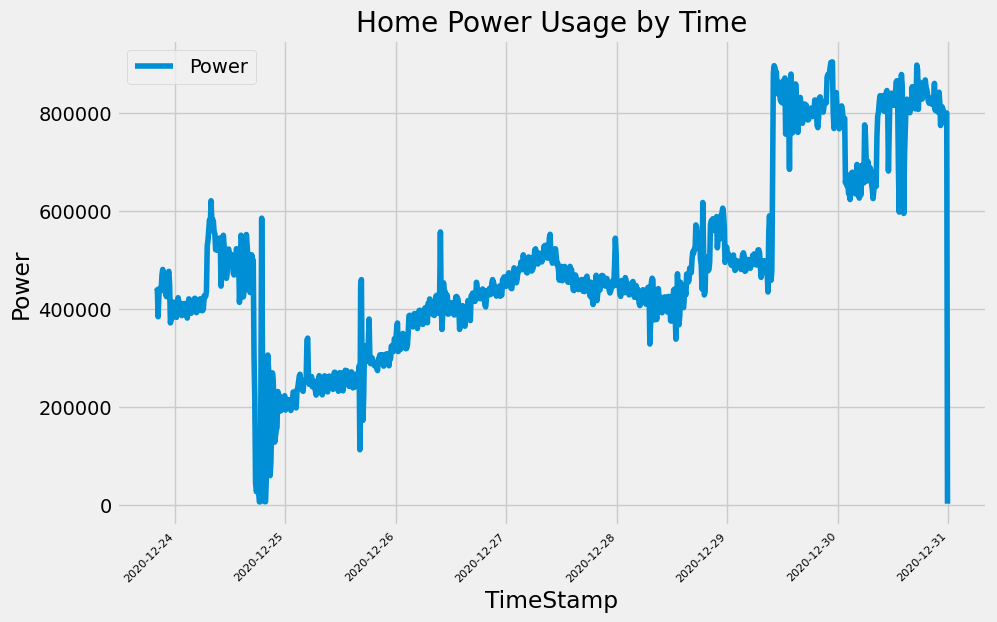

In [ ]:
# elde ettiğimiz verileri bir görselleştirelim
plt.figure(figsize=(10, 6))
plt.plot(df['timestamp'], df['total_power'], label='Power')
plt.title('Home Power Usage by Time')
plt.xlabel('TimeStamp')
plt.ylabel('Power')
plt.legend()
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.show()

In [ ]:
FEATURES = ['radiator_309.csv', 'fridge_284.csv',	'dehumidifier_310.csv',	'computer_44.csv']
TARGET = 'total_power'

In [ ]:
train = df.loc[df['timestamp'] < '2020-12-29', ['timestamp', 'radiator_309.csv', 'fridge_284.csv',	'dehumidifier_310.csv',	'computer_44.csv', 'total_power']]
validation = df.loc[(df['timestamp'] >= '2020-12-29') & (df['timestamp'] < '2020-12-30'), ['timestamp', 'radiator_309.csv', 'fridge_284.csv',	'dehumidifier_310.csv',	'computer_44.csv', 'total_power']]
test = df.loc[(df['timestamp'] >= '2020-12-30') & (df['timestamp'] < '2020-12-30 23:50:00+00:00'), ['timestamp', 'radiator_309.csv', 'fridge_284.csv',	'dehumidifier_310.csv',	'computer_44.csv', 'total_power']]

In [ ]:
X_train = train[FEATURES]
y_train = train[[TARGET]] # burada dataframe olarak tutmak için 2 tane [[]] kullanıyorum

X_val = validation[FEATURES]
y_val = validation[[TARGET]]

X_test = test[FEATURES]
y_test = test[[TARGET]]
X_train, y_train, X_val, y_val, X_test, y_test

(     radiator_309.csv  fridge_284.csv  dehumidifier_310.csv  computer_44.csv
 0           357759.00        13832.00                1800.0          62298.5
 1           351203.25        26654.75                1800.0          59041.5
 2           297021.50        25119.00                1786.5          59531.0
 3           291477.50        24439.75                1800.0         108607.0
 4           298882.00         4791.00                1800.0         136079.5
 ..                ...             ...                   ...              ...
 739         421427.50        18096.50                1399.5         152691.5
 740         420257.00         1169.00                1402.5         143333.5
 741         426953.50         1157.00                1530.0          64703.5
 742         431319.50         3969.50                1390.0          63623.0
 743         432786.00        26087.00                1732.0          65083.5
 
 [744 rows x 4 columns],
      total_power
 0      435689.50
 

In [ ]:
y_test.values.reshape(-1, 1)

array([[784619.5       ],
       [777903.75      ],
       [767016.5       ],
       [784651.        ],
       [805852.75      ],
       [813865.5       ],
       [804187.75      ],
       [785906.25      ],
       [788421.5       ],
       [788275.        ],
       [656812.        ],
       [671345.5       ],
       [650412.5       ],
       [661986.75      ],
       [635228.5       ],
       [636369.5       ],
       [622736.5       ],
       [675207.5       ],
       [656756.75      ],
       [678505.5       ],
       [644854.25      ],
       [644319.5       ],
       [655033.5       ],
       [634172.        ],
       [655143.5       ],
       [694286.25      ],
       [643548.5       ],
       [674611.25      ],
       [625620.5       ],
       [662921.5       ],
       [631498.5       ],
       [691991.        ],
       [655649.        ],
       [693960.        ],
       [656717.5       ],
       [775031.75      ],
       [755702.5       ],
       [701787.5       ],
       [6605

In [ ]:
scaler = MinMaxScaler()
X_train.loc[:, FEATURES] = scaler.fit_transform(X_train.loc[:, FEATURES])
X_val.loc[:, FEATURES] = scaler.fit_transform(X_val.loc[:, FEATURES])
X_test.loc[:, FEATURES] = scaler.fit_transform(X_test.loc[:, FEATURES])

y_train[TARGET] = scaler.fit_transform(y_train[TARGET].values.reshape(-1, 1))
y_val[TARGET] = scaler.fit_transform(y_val[TARGET].values.reshape(-1, 1))
y_test[TARGET] = scaler.fit_transform(y_test[TARGET].values.reshape(-1, 1))
# X_train, y_train, X_val, y_val

<ipython-input-567-11d487c0102e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.loc[:, FEATURES] = scaler.fit_transform(X_train.loc[:, FEATURES])
<ipython-input-567-11d487c0102e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val.loc[:, FEATURES] = scaler.fit_transform(X_val.loc[:, FEATURES])
<ipython-input-567-11d487c0102e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.loc[:, FEATURES] = scaler.fit_transform(X_

In [ ]:
n_input = 4
train_generator = TimeseriesGenerator(X_train[FEATURES].values, y_train[TARGET].values, length=n_input, batch_size=4)
val_generator = TimeseriesGenerator(X_val[FEATURES].values, y_val[TARGET].values, length=n_input, batch_size=4)
test_generator = TimeseriesGenerator(X_test[FEATURES].values, y_test[TARGET].values, length=n_input, batch_size=4)
n_features = len(FEATURES)

In [ ]:
print(train_generator[0])
print(val_generator[0])

(array([[[6.42738079e-01, 1.14069021e-01, 2.49974318e-03, 4.03313057e-01],
        [6.30914684e-01, 2.29159000e-01, 2.49974318e-03, 3.81813501e-01],
        [5.33197078e-01, 2.15374950e-01, 2.43810567e-03, 3.85044705e-01],
        [5.23198390e-01, 2.09278374e-01, 2.49974318e-03, 7.08996874e-01]],

       [[6.30914684e-01, 2.29159000e-01, 2.49974318e-03, 3.81813501e-01],
        [5.33197078e-01, 2.15374950e-01, 2.43810567e-03, 3.85044705e-01],
        [5.23198390e-01, 2.09278374e-01, 2.49974318e-03, 7.08996874e-01],
        [5.36552518e-01, 3.29219584e-02, 2.49974318e-03, 8.90343683e-01]],

       [[5.33197078e-01, 2.15374950e-01, 2.43810567e-03, 3.85044705e-01],
        [5.23198390e-01, 2.09278374e-01, 2.49974318e-03, 7.08996874e-01],
        [5.36552518e-01, 3.29219584e-02, 2.49974318e-03, 8.90343683e-01],
        [5.37570602e-01, 5.78916663e-04, 2.47006586e-03, 8.79316661e-01]],

       [[5.23198390e-01, 2.09278374e-01, 2.49974318e-03, 7.08996874e-01],
        [5.36552518e-01, 3.2921

In [ ]:
print(X_train[FEATURES].shape[1])

4


In [ ]:
X_train.shape[1]

4

In [ ]:
print(X_train[FEATURES].values.shape)  # X_train_array'in şeklini kontrol et

(744, 4)


In [ ]:
"""m = Sequential()

m.add(LSTM(units=128, input_shape=(n_input, 1),return_sequences=True))
#m.add(attention(return_sequences=True))
m.add(Dropout(0.2))

m.add(LSTM(units=64,return_sequences=True,activation='tanh'))
#m.add(attention(return_sequences=True))
m.add(Dropout(0.2))

m.add(LSTM(units=32,return_sequences=True))
m.add(Dropout(0.2))
#m.add(attention(return_sequences=True))
m.add(LSTM(units=16,return_sequences=True))
m.add(Dropout(0.35))
#m.add(Dense(units=10))
m.add(Dense(units=1))

m.summary()

m.compile(optimizer=optimizers.RMSprop(
    learning_rate=0.00001,
    rho=0.7,
    momentum=0.9,
    epsilon=1e-7,
    centered=True,
    name="RMSprop",
),loss='mean_squared_error',metrics = ["mae"])"""

'm = Sequential()\n\nm.add(LSTM(units=128, input_shape=(n_input, 1),return_sequences=True))\n#m.add(attention(return_sequences=True))\nm.add(Dropout(0.2))\n\nm.add(LSTM(units=64,return_sequences=True,activation=\'tanh\'))\n#m.add(attention(return_sequences=True))\nm.add(Dropout(0.2))\n\nm.add(LSTM(units=32,return_sequences=True))\nm.add(Dropout(0.2))\n#m.add(attention(return_sequences=True))\nm.add(LSTM(units=16,return_sequences=True))\nm.add(Dropout(0.35))\n#m.add(Dense(units=10))\nm.add(Dense(units=1))\n\nm.summary()\n\nm.compile(optimizer=optimizers.RMSprop(\n    learning_rate=0.00001,\n    rho=0.7,\n    momentum=0.9,\n    epsilon=1e-7,\n    centered=True,\n    name="RMSprop",\n),loss=\'mean_squared_error\',metrics = ["mae"])'

In [ ]:
model = Sequential()
model.add(LSTM(units=30, activation='relu', input_shape=(n_input, n_features), return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(units=1))

model.summary()
optimizer = Adam(learning_rate = 0.0001)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', 'mse'])

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_57 (LSTM)              (None, 4, 30)             4200      
                                                                 
 dense_29 (Dense)            (None, 4, 1)              31        
                                                                 
Total params: 4231 (16.53 KB)
Trainable params: 4231 (16.53 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = model.fit(train_generator, epochs=10, batch_size=32, validation_data=val_generator)

Epoch 1/10
185/185 [==============================] - 7s 21ms/step - loss: 0.3480 - mae: 0.5640 - mse: 0.3480 - val_loss: 0.3096 - val_mae: 0.4506 - val_mse: 0.3096
Epoch 2/10
185/185 [==============================] - 4s 20ms/step - loss: 0.2386 - mae: 0.4538 - mse: 0.2386 - val_loss: 0.2112 - val_mae: 0.3745 - val_mse: 0.2112
Epoch 3/10
185/185 [==============================] - 4s 22ms/step - loss: 0.1487 - mae: 0.3331 - mse: 0.1487 - val_loss: 0.1389 - val_mae: 0.3062 - val_mse: 0.1389
Epoch 4/10
185/185 [==============================] - 4s 20ms/step - loss: 0.1057 - mae: 0.2680 - mse: 0.1057 - val_loss: 0.1203 - val_mae: 0.2863 - val_mse: 0.1203
Epoch 5/10
185/185 [==============================] - 5s 27ms/step - loss: 0.0924 - mae: 0.2490 - mse: 0.0924 - val_loss: 0.1136 - val_mae: 0.2818 - val_mse: 0.1136
Epoch 6/10
185/185 [==============================] - 4s 21ms/step - loss: 0.0811 - mae: 0.2315 - mse: 0.0811 - val_loss: 0.1084 - val_mae: 0.2782 - val_mse: 0.1084
Epoch 7/10

In [ ]:
predictions = model.predict(test_generator)

35/35 [==============================] - 0s 3ms/step


In [ ]:
model.evaluate(test_generator)

35/35 [==============================] - 0s 4ms/step - loss: 0.1224 - mae: 0.2917 - mse: 0.1224


[0.12242672592401505, 0.2916954457759857, 0.12242672592401505]

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse'])


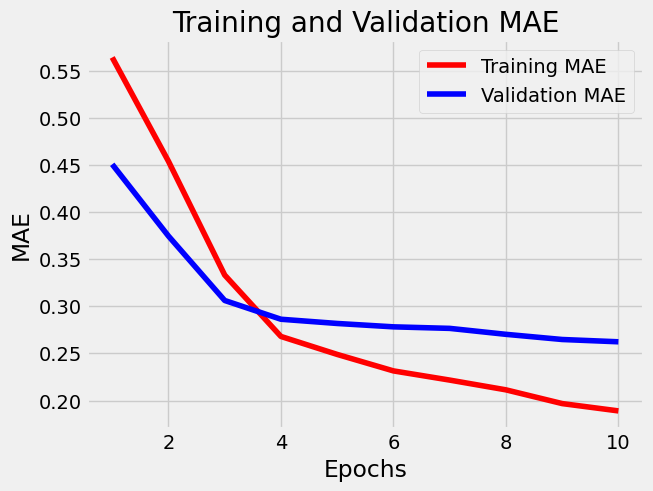

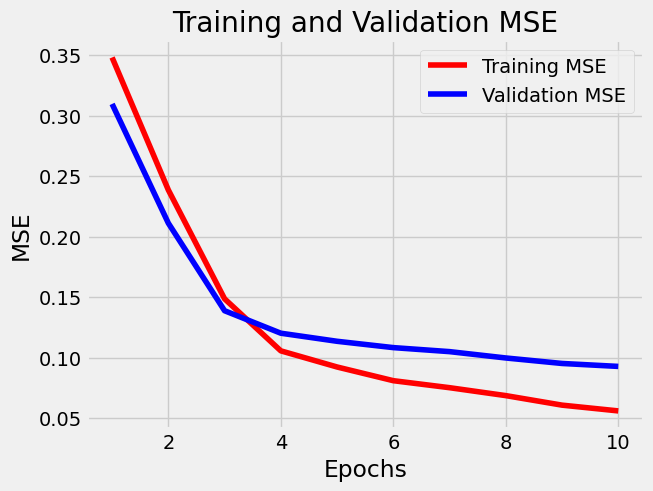

In [ ]:
# MAE ve MSE değerlerini al
mae_history = history.history['mae']
mse_history = history.history['mse']
val_mae_history = history.history['val_mae']
val_mse_history = history.history['val_mse']

# Epoch sayıları
epochs = range(1, len(mae_history) + 1)

# MAE değerlerini çiz
plt.plot(epochs, mae_history, 'r', label='Training MAE')
plt.plot(epochs, val_mae_history, 'b', label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

# Grafiği göster
plt.show()

# MSE değerlerini çiz
plt.plot(epochs, mse_history, 'r', label='Training MSE')
plt.plot(epochs, val_mse_history, 'b', label='Validation MSE')
plt.title('Training and Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()

# Grafiği göster
plt.show()

In [ ]:
"""from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
def show_scores(model):
    train_preds = model.predict(train_generator)
    val_preds = model.predict(val_generator)
    test_preds = model.predict(test_generator)
    scores = {"Traning MAE":mean_absolute_error(y_train,train_preds),
              "Training R^2": r2_score(y_train,train_preds),
              "Training MSE": mean_squared_error(y_train,train_preds),
              "Validation MAE":mean_absolute_error(y_val,val_preds),
              "Validation R^2": r2_score(y_val,val_preds),
              "Validation MSE": mean_squared_error(y_val,val_preds),
              "Test MAE":mean_absolute_error(y_test,test_preds),
              "Test R^2": r2_score(y_test,test_preds),
              "Test MSE": mean_squared_error(y_test,test_preds),
              }
    return scores
metric_results = pd.DataFrame(show_scores(model).values(),index=show_scores(model).keys(),columns=["LSTM Dataset:1"])
metric_results"""

## Linear Model

In [ ]:
# bu kod index'leri sıfırlamak için çünkü index değerleri farklı olunca hep NaT değerler görünüyor düzenleme için sadece
gerekli_dosyalar = ["radiator_309.csv", "fridge_284.csv", "dehumidifier_310.csv", "computer_44.csv"]
for i in range(len(csvlist)):
  csvlist[i] = csvlist[i].reset_index(drop=True)
  csvlist[i] = csvlist[i].rename(columns={'power': gerekli_dosyalar[i]})
csvlist[0]

,timestamp,radiator_309.csv
0,2020-12-23 20:00:00+00:00,1190.0
1,2020-12-23 20:00:01+00:00,1190.0
2,2020-12-23 20:00:02+00:00,1190.0
3,2020-12-23 20:00:03+00:00,1190.0
4,2020-12-23 20:00:04+00:00,1190.0
...,...,...
618596,2020-12-30 23:49:56+00:00,1235.0
618597,2020-12-30 23:49:57+00:00,1235.0
618598,2020-12-30 23:49:58+00:00,1235.0
618599,2020-12-30 23:49:59+00:00,1235.0


In [ ]:
# daha önce listeye aldığımız tüm csv dosyalarını burada birleştiriyoruz ve hem indexler hem değerler düzgün görünüyor
df = pd.concat(csvlist, axis=1)

# tüm enerjiyi hesaplamak için power değerlerini row'a göre topluyorum
df['total_power'] = df.iloc[:, 1::2].sum(axis=1)

# gereksiz timestamp ve power sütunlarından kurtulma kısmı
timestampcol = df['timestamp'].iloc[:, 0]
df = df.loc[:, ['timestamp', 'radiator_309.csv', 'fridge_284.csv', 'dehumidifier_310.csv', 'computer_44.csv', 'total_power']]
df = df.drop(columns=['timestamp'])
df.insert(0, 'timestamp', timestampcol)
df

,timestamp,radiator_309.csv,fridge_284.csv,dehumidifier_310.csv,computer_44.csv,total_power
0,2020-12-23 20:00:00+00:00,1190.0,2.0,3.0,108.0,1303.0
1,2020-12-23 20:00:01+00:00,1190.0,2.0,3.0,109.0,1304.0
2,2020-12-23 20:00:02+00:00,1190.0,2.0,3.0,104.0,1299.0
3,2020-12-23 20:00:03+00:00,1190.0,2.0,3.0,113.0,1308.0
4,2020-12-23 20:00:04+00:00,1190.0,2.0,3.0,119.0,1314.0
...,...,...,...,...,...,...
618596,2020-12-30 23:49:56+00:00,1235.0,44.0,324.0,93.0,1696.0
618597,2020-12-30 23:49:57+00:00,1235.0,44.0,324.0,92.0,1695.0
618598,2020-12-30 23:49:58+00:00,1235.0,44.0,324.0,92.0,1695.0
618599,2020-12-30 23:49:59+00:00,1235.0,44.0,324.0,93.0,1696.0


In [ ]:
# 10 dakikalık aralıklara bölerek toplam
columns_to_resample = ['radiator_309.csv', 'fridge_284.csv', 'dehumidifier_310.csv', 'computer_44.csv']

df_total_power = df.resample('10Min', on='timestamp')['total_power'].sum().to_frame(name='total_power')
df_total_power.reset_index(inplace=True)

df_radiator_309csv = df.resample('10Min', on='timestamp')['radiator_309.csv'].sum().to_frame(name='radiator_309.csv')
df_radiator_309csv.reset_index(inplace=True)

df_fridge_284csv = df.resample('10Min', on='timestamp')['fridge_284.csv'].sum().to_frame(name='fridge_284.csv')
df_fridge_284csv.reset_index(inplace=True)

df_dehumidifier_310csv = df.resample('10Min', on='timestamp')['dehumidifier_310.csv'].sum().to_frame(name='dehumidifier_310.csv')
df_dehumidifier_310csv.reset_index(inplace=True)

df_computer_44csv = df.resample('10Min', on='timestamp')['computer_44.csv'].sum().to_frame(name='computer_44.csv')
df_computer_44csv.reset_index(inplace=True)

# df_total_power, df_radiator_309csv, df_fridge_284csv, df_dehumidifier_310csv, df_computer_44csv are the resampled DataFrames

In [ ]:
# Merge the resampled DataFrames on the 'timestamp' column
result_df = df_total_power
result_df = pd.merge(result_df, df_radiator_309csv, on='timestamp', how='outer')
result_df = pd.merge(result_df, df_fridge_284csv, on='timestamp', how='outer')
result_df = pd.merge(result_df, df_dehumidifier_310csv, on='timestamp', how='outer')
result_df = pd.merge(result_df, df_computer_44csv, on='timestamp', how='outer')

# Now 'result_df' contains the merged DataFrames with a single 'timestamp' column
df = result_df
df

,timestamp,total_power,radiator_309.csv,fridge_284.csv,dehumidifier_310.csv,computer_44.csv
0,2020-12-23 20:00:00+00:00,435689.50,357759.00,13832.00,1800.0,62298.50
1,2020-12-23 20:10:00+00:00,438699.50,351203.25,26654.75,1800.0,59041.50
2,2020-12-23 20:20:00+00:00,383458.00,297021.50,25119.00,1786.5,59531.00
3,2020-12-23 20:30:00+00:00,426324.25,291477.50,24439.75,1800.0,108607.00
4,2020-12-23 20:40:00+00:00,441552.50,298882.00,4791.00,1800.0,136079.50
...,...,...,...,...,...,...
1027,2020-12-30 23:10:00+00:00,795831.00,527650.00,15708.00,196192.0,56281.00
1028,2020-12-30 23:20:00+00:00,780747.00,526458.00,1189.00,196837.0,56263.00
1029,2020-12-30 23:30:00+00:00,795840.75,540740.50,1167.00,198170.0,55763.25
1030,2020-12-30 23:40:00+00:00,799401.25,535972.25,9920.00,197725.0,55784.00


In [ ]:
FEATURES = ['radiator_309.csv', 'fridge_284.csv',	'dehumidifier_310.csv',	'computer_44.csv']
TARGET = 'total_power'

In [ ]:
train = df.loc[df['timestamp'] < '2020-12-29', ['timestamp', 'radiator_309.csv', 'fridge_284.csv',	'dehumidifier_310.csv',	'computer_44.csv', 'total_power']]
validation = df.loc[(df['timestamp'] >= '2020-12-29') & (df['timestamp'] < '2020-12-30'), ['timestamp', 'radiator_309.csv', 'fridge_284.csv',	'dehumidifier_310.csv',	'computer_44.csv', 'total_power']]
test = df.loc[(df['timestamp'] >= '2020-12-30') & (df['timestamp'] < '2020-12-30 23:50:00+00:00'), ['timestamp', 'radiator_309.csv', 'fridge_284.csv',	'dehumidifier_310.csv',	'computer_44.csv', 'total_power']]

In [ ]:
X_train = train[FEATURES]
y_train = train[[TARGET]]

X_val = validation[FEATURES]
y_val = validation[[TARGET]]

X_test = test[FEATURES]
y_test = test[[TARGET]]

In [ ]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(744, 4) (744, 1) (143, 4) (143, 1)


In [ ]:
scaler = MinMaxScaler()
X_train.loc[:, FEATURES] = scaler.fit_transform(X_train.loc[:, FEATURES])
X_val.loc[:, FEATURES] = scaler.fit_transform(X_val.loc[:, FEATURES])
X_test.loc[:, FEATURES] = scaler.fit_transform(X_test.loc[:, FEATURES])

y_train[TARGET] = scaler.fit_transform(y_train[TARGET].values.reshape(-1, 1))
y_val[TARGET] = scaler.fit_transform(y_val[TARGET].values.reshape(-1, 1))
y_test[TARGET] = scaler.fit_transform(y_test[TARGET].values.reshape(-1, 1))
# X_train, y_train, X_val, y_val, X_test, y_test

<ipython-input-647-8c1d2c692049>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.loc[:, FEATURES] = scaler.fit_transform(X_train.loc[:, FEATURES])
<ipython-input-647-8c1d2c692049>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val.loc[:, FEATURES] = scaler.fit_transform(X_val.loc[:, FEATURES])
<ipython-input-647-8c1d2c692049>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.loc[:, FEATURES] = scaler.fit_transform(X_

In [ ]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((744, 4), (744, 1), (144, 4), (144, 1), (143, 4), (143, 1))

In [ ]:
# Predictions on training set
y_pred_train = model.predict(X_train)

# Predictions on validation set
y_pred_val = model.predict(X_val)

# Predictions on test set
y_pred_test = model.predict(X_test)

# If needed, inverse transform the scaled predictions back to the original scale
y_pred_train_original = scaler.inverse_transform(y_pred_train.reshape(-1, 1))
y_pred_val_original = scaler.inverse_transform(y_pred_val.reshape(-1, 1))
y_pred_test_original = scaler.inverse_transform(y_pred_test.reshape(-1, 1))

# Evaluate the model
mae_train = mean_absolute_error(y_train, y_pred_train_original)
mse_train = mean_squared_error(y_train, y_pred_train_original)

mae_val = mean_absolute_error(y_val, y_pred_val_original)
mse_val = mean_squared_error(y_val, y_pred_val_original)

mae_test = mean_absolute_error(y_test, y_pred_test_original)
mse_test = mean_squared_error(y_test, y_pred_test_original)

# Print evaluation metrics
print(f'Training MAE: {mae_train}, Training MSE: {mse_train}')
print(f'Validation MAE: {mae_val}, Validation MSE: {mse_val}')
print(f'Test MAE: {mae_test}, Test MSE: {mse_test}')


Training MAE: 9.812160814482422e-17, Training MSE: 1.644501013600404e-32
Validation MAE: 0.2517876655943826, Validation MSE: 0.069111192311083
Test MAE: 0.44421733029529265, Test MSE: 0.2116974832300727


In [ ]:
model = LinearRegression()

model.fit(X_train, y_train)

# Predictions on training set
y_pred_train = model.predict(X_train)
# Predictions on validation set
y_pred_val = model.predict(X_val)
# Predictions on test set
y_pred_test = model.predict(X_test)

# If needed, inverse transform the scaled predictions back to the original scale
y_pred_train_original = scaler.inverse_transform(y_pred_train.reshape(-1, 1))
y_pred_val_original = scaler.inverse_transform(y_pred_val.reshape(-1, 1))
y_pred_test_original = scaler.inverse_transform(y_pred_test.reshape(-1, 1))

# If needed, inverse transform the scaled predictions back to the original scale
y_pred_train = scaler.inverse_transform(y_train[TARGET].values.reshape(-1, 1))
y_pred_val = scaler.inverse_transform(y_val[TARGET].values.reshape(-1, 1))
y_pred_test = scaler.inverse_transform(y_test[TARGET].values.reshape(-1, 1))

# Evaluate the model
mae_train = mean_absolute_error(y_pred_train, y_pred_train_original)
mse_train = mean_squared_error(y_pred_train, y_pred_train_original)

mae_val = mean_absolute_error(y_pred_val, y_pred_val_original)
mse_val = mean_squared_error(y_pred_val, y_pred_val_original)

mae_test = mean_absolute_error(y_pred_test, y_pred_test_original)
mse_test = mean_squared_error(y_pred_test, y_pred_test_original)

# Print evaluation metrics
print(f'Training MAE: {mae_train}, Training MSE: {mse_train}')
print(f'Validation MAE: {mae_val}, Validation MSE: {mse_val}')
print(f'Test MAE: {mae_test}, Test MSE: {mse_test}')

Training MAE: 9.812160814482422e-17, Training MSE: 1.644501013600404e-32
Validation MAE: 0.2517876655943826, Validation MSE: 0.069111192311083
Test MAE: 0.44421733029529265, Test MSE: 0.2116974832300727


In [ ]:
# Get the coefficients and intercept
coefficients = model.coef_
intercept = model.intercept_

# Print the coefficients and intercept
print("Coefficients:", coefficients)
print("Intercept:", intercept)

Coefficients: [[0.90193552 0.1812337  0.3562739  0.24642431]]
Intercept: [-0.00085318]


In [ ]:
score = np.sqrt(mean_squared_error(y_train, y_pred))
print(f'RMSE Score on Test Data: {score:0.4}')

RMSE Score on Test Data: 4.118e+05
